In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import (
    ts_read_daily_tickets,
    read_ts_tree,
    read_proper_ts_tree,
)
from darts import TimeSeries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
# original, do not use
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))
# run `just generate_data`
tree = read_proper_ts_tree(get_correct_data_path("custom_data/tree_proper.csv"))

In [3]:
df

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26
...,...,...,...
418322,9,2020-08-30,1
418323,9,2020-09-13,1
418324,9,2020-09-16,1
418325,9,2020-09-17,1


In [4]:
tree

,queueId,level,immediateDescendants,allDescendants,full_load
0,1,2,[100286],"[1, 100286]",142457
1,4097,3,[],[4097],4329
2,5,1,"[6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 117,...","[5, 6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 1...",0
3,6,2,[],[6],0
4,7,2,[100253],"[7, 100253]",105046
...,...,...,...,...,...
1646,4052,2,"[4137, 1062]","[1062, 2835, 4052, 4137]",183870
1647,4062,4,[],[4062],0
1648,4082,2,[],[4082],157
1649,4087,2,"[3536, 3836]","[3536, 3836, 4087]",397990


# Проверка аномалий в данных

Анализ аномалий во временных рядах необходим для своевременного выявления отклонений, которые могут сигнализировать о проблемах или важных изменениях в процессе. Быстрое обнаружение аномалий позволяет оперативно реагировать на потенциальные риски, предотвращать возможные убытки и принимать обоснованные решения.

In [5]:
df.describe()

,queueId,date,new_tickets
count,418327.000000,418327,418327.000000
mean,20450.068822,2019-03-01 08:31:49.778714368,36.909838
min,1.000000,2017-01-01 00:00:00,1.000000
25%,2017.000000,2018-04-20 00:00:00,5.000000
50%,2752.000000,2019-04-25 00:00:00,14.000000
75%,4162.000000,2020-02-04 00:00:00,37.000000
max,101359.000000,2020-09-30 00:00:00,22072.000000
std,37997.424512,NaN,89.480679


In [6]:
df.isnull().sum()
# Нулевых значений нет

queueId        0
date           0
new_tickets    0
dtype: int64

In [7]:
print(np.isnan(df).sum())
# Пропусков нет

queueId        0
date           0
new_tickets    0
dtype: int64


Но такая проверка на пропуски для нас не очень информативна. Необходимо проверить - есть ли такие очереди, в которые не поступило тикетов, в какой то день.

In [8]:
min_date = df["date"].min()
max_date = df["date"].max()

unique_queues = df["queueId"].unique()

# Создание датафрейма со всеми возможными комбинациями queueId и дат
date_range = pd.date_range(start=min_date, end=max_date, freq="D")
all_combinations = pd.MultiIndex.from_product(
    [unique_queues, date_range], names=["queueId", "date"]
)
full_df = pd.DataFrame(index=all_combinations).reset_index()

# Слияние с основным датасетом для нахождения пропусков
merged_df = full_df.merge(df, on=["queueId", "date"], how="left")

# Нахождение комбинаций queueId и date, где не было новых тикетов
queues_without_tickets = merged_df[merged_df["new_tickets"].isnull()]

print(
    "Очереди, которые не получили тикеты на определенные даты:\n",
    queues_without_tickets,
)

print("Количество таких очередей:", len(queues_without_tickets["queueId"].unique()))

Очереди, которые не получили тикеты на определенные даты:
          queueId       date  new_tickets
2738      100034 2017-01-01          NaN
2739      100034 2017-01-02          NaN
2740      100034 2017-01-03          NaN
2741      100034 2017-01-04          NaN
2742      100034 2017-01-05          NaN
...          ...        ...          ...
1133526        9 2020-09-25          NaN
1133527        9 2020-09-26          NaN
1133528        9 2020-09-27          NaN
1133529        9 2020-09-28          NaN
1133531        9 2020-09-30          NaN

[715205 rows x 3 columns]
Количество таких очередей: 785


Отсюда видно, что пропусков довольно много. 785 очередей не получили ни одного тикета в какие то дни.

In [9]:
grouped_df = df.groupby("queueId")["new_tickets"].agg(["count"]).reset_index()
grouped_df
# Сколько всего тикетов в очередях

,queueId,count
0,1,1369
1,7,1368
2,9,222
3,10,1369
4,13,1368
...,...,...
823,101349,7
824,101350,8
825,101351,7
826,101352,8


Теперь найдем выбросы. 

Была использована модель для детектирования аномалий из библиотеки darts

In [10]:
ts = TimeSeries.from_dataframe(
    df.groupby("date").sum().reset_index(), "date", "new_tickets"
)

In [11]:
df_total = df.groupby("date")["new_tickets"].sum().reset_index()
ts_total = TimeSeries.from_dataframe(df_total, "date", "new_tickets")

Так же для нахождения аномалий применим алгоритм IsolationForest

In [12]:
outliers_fraction = float(0.01)

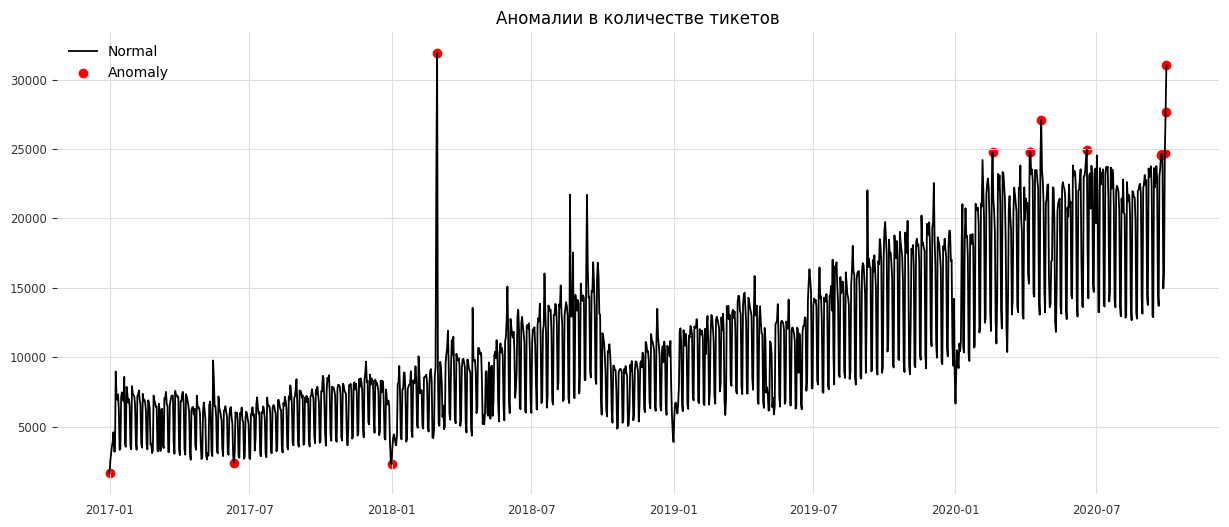

In [13]:
grouped_df = df.groupby("date")["new_tickets"].sum().reset_index()
grouped_df.set_index("date", inplace=True)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(grouped_df["new_tickets"].values.reshape(-1, 1))
scaled_data = pd.DataFrame(np_scaled, index=grouped_df.index, columns=["new_tickets"])

# Обучение Isolation Forest для выявления аномалий
outliers_fraction = 0.01
model = IsolationForest(contamination=outliers_fraction, random_state=42)
grouped_df["anomaly"] = model.fit_predict(scaled_data)


fig, ax = plt.subplots(figsize=(15, 6))
anomalies = grouped_df[grouped_df["anomaly"] == -1]

ax.plot(grouped_df.index, grouped_df["new_tickets"], color="black", label="Normal")
ax.scatter(anomalies.index, anomalies["new_tickets"], color="red", label="Anomaly")
plt.title("Аномалии в количестве тикетов")
plt.legend()
plt.show()

На графике можно увидеть выделенные аномальные точки

In [14]:
df.duplicated(["date", "queueId"]).sum()
# Дубликатов нет

0

# Тренд и сезонность в данных

In [15]:
from darts.utils import statistics
from darts.utils.utils import ModelMode

In [16]:
trend, seasonality = statistics.extract_trend_and_seasonality(
    ts_total, model=ModelMode.ADDITIVE, method="MSTL"
)

<Axes: xlabel='date'>

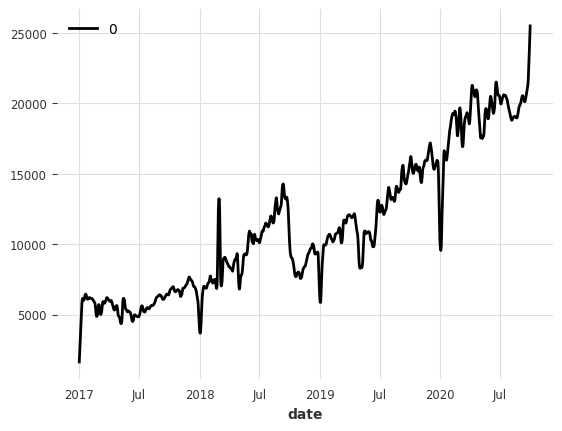

In [17]:
trend.plot()

Видна сильная недельная сезональность

<Axes: xlabel='date'>

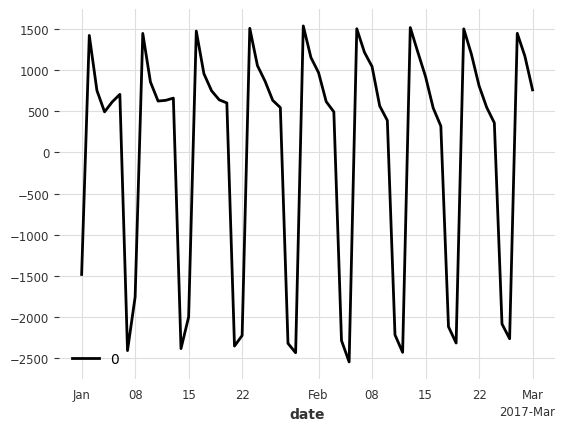

In [18]:
seasonality[:60].plot()

In [19]:
ts_total_monthly = TimeSeries.from_dataframe(
    ts_total.pd_dataframe().resample("ME").sum()
)

<Axes: xlabel='date'>

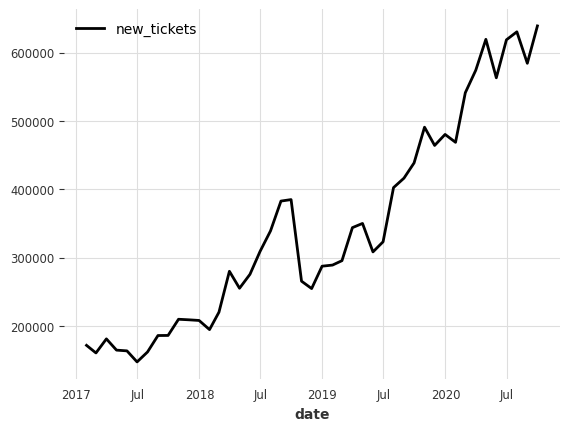

In [20]:
ts_total_monthly.plot()

In [21]:
trend, seasonality = statistics.extract_trend_and_seasonality(ts_total_monthly)

Формально годовой сезональности нет

In [22]:
statistics.check_seasonality(ts_total_monthly, 12)

(False, 0)

Видим увеличение тикетов в апреле и сентябре, октябре. Падение в декабре и июне.

<Axes: xlabel='date'>

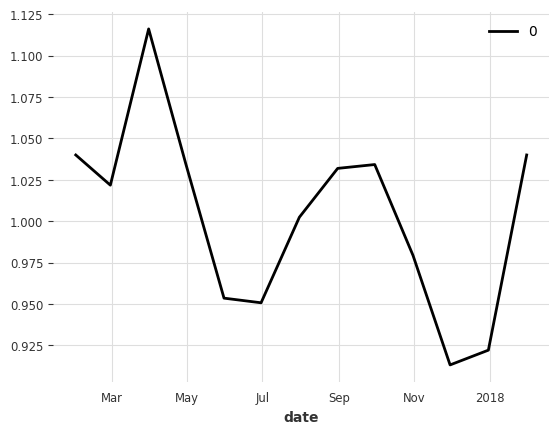

In [23]:
seasonality[:13].plot()

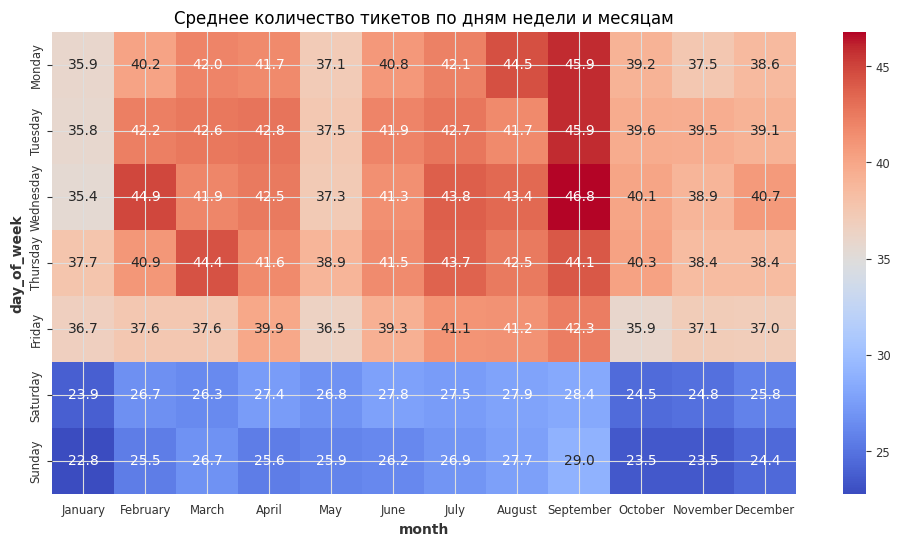

In [24]:
df["day_of_week"] = df["date"].dt.day_name()
df["month"] = df["date"].dt.month_name()

day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]


df["day_of_week"] = pd.Categorical(
    df["day_of_week"], categories=day_order, ordered=True
)
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)


heatmap_data = df.pivot_table(
    index="day_of_week",
    columns="month",
    values="new_tickets",
    aggfunc="mean",
    observed=False,
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Среднее количество тикетов по дням недели и месяцам")
plt.show()

Из тепловой карты видно, что самый загруженный месяц это сентябрь. Так же видно, что в выходные запросов в тех. поддержку значительно меньше, чем в будние дни.  

Необходимо найти сумму тикетов дочерних очередей для их родителей. Далее нужно построить графики сезонности, тренда и шумов для самых популярных родительских очередей (top_queues).

In [25]:
def analyze_queues_stl_children(df, tree, top_queues):
    for queue_id in top_queues:
        if queue_id in df["queueId"].values:
            parent_row = tree[tree["queueId"] == queue_id]
            if not parent_row.empty:
                children_ids = parent_row.iloc[0]["immediateDescendants"]
                # Фильтруем только дочерние очереди
                queue_data = (
                    df[df["queueId"].isin(children_ids)]
                    .groupby("date")["new_tickets"]
                    .sum()
                    .reset_index()
                )
                queue_data.set_index("date", inplace=True)

                stl = STL(queue_data, seasonal=7)
                result = stl.fit()

                # График оригинального временного ряда
                plt.figure(figsize=(12, 6))
                plt.plot(queue_data, label="График временного ряда", color="green")
                plt.title(f"График временного ряда для очереди {queue_id}")
                plt.xlabel("Date")
                plt.ylabel("Number of New Tickets")
                plt.legend()
                plt.show()

                # График тренда
                plt.figure(figsize=(12, 6))
                plt.plot(result.trend, label="Тренд", color="orange")
                plt.title("Тренд")
                plt.xlabel("Date")
                plt.ylabel("Value")
                plt.legend()
                plt.show()

                # График сезонности
                plt.figure(figsize=(12, 6))
                plt.plot(result.seasonal, label="Сезонность", color="blue")
                plt.title("Сезонность")
                plt.xlabel("Date")
                plt.ylabel("Value")
                plt.legend()
                plt.show()

                # График остатков
                plt.figure(figsize=(12, 6))
                plt.plot(result.resid, label="Остатки", color="red")
                plt.title("Остатки")
                plt.xlabel("Date")
                plt.ylabel("Value")
                plt.legend()
                plt.show()


In [26]:
top_queues = list(tree.sort_values("full_load", ascending=False).queueId.values[:10])

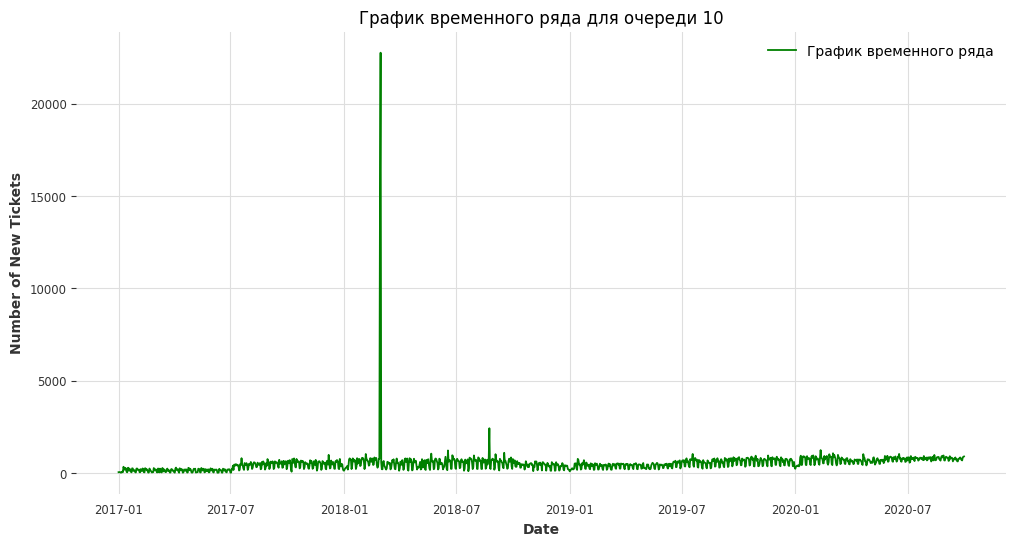

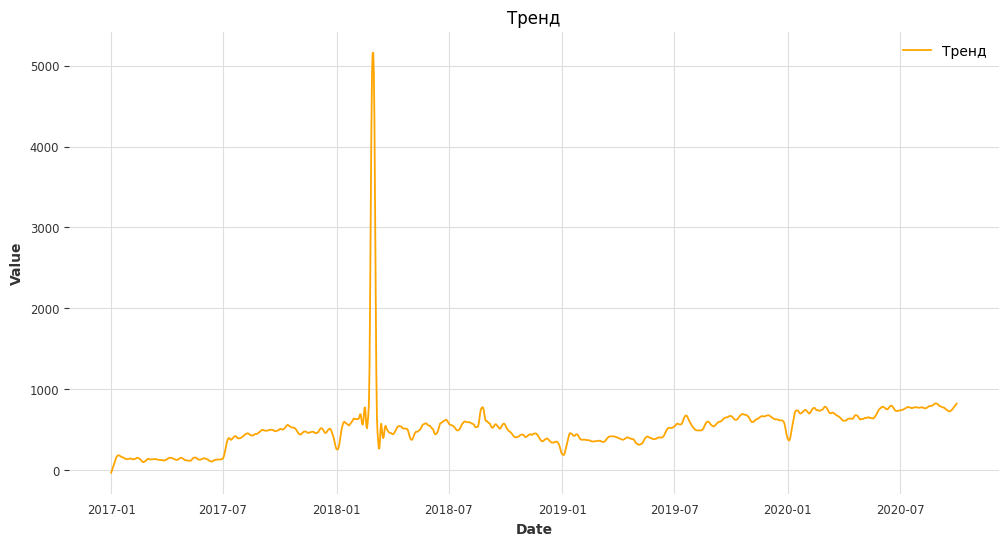

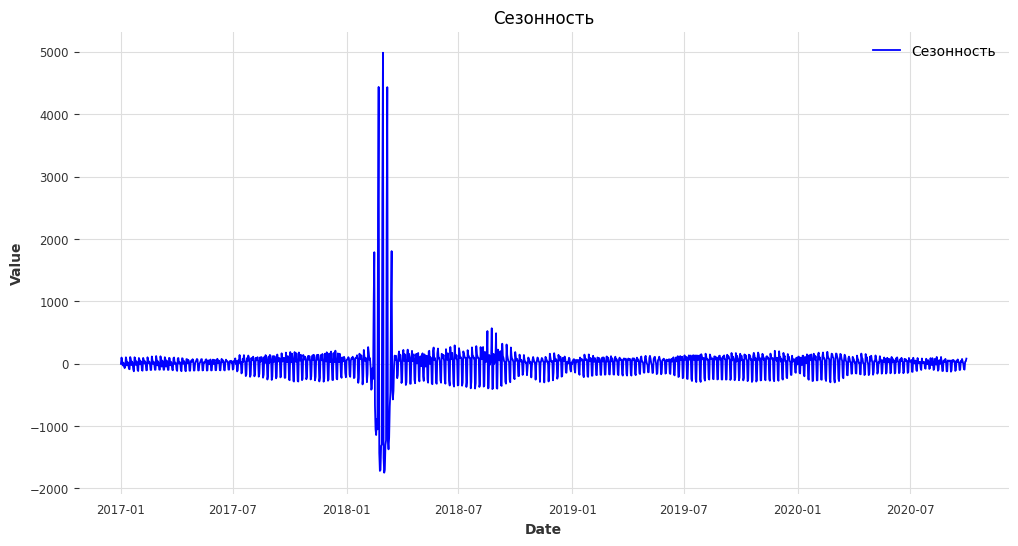

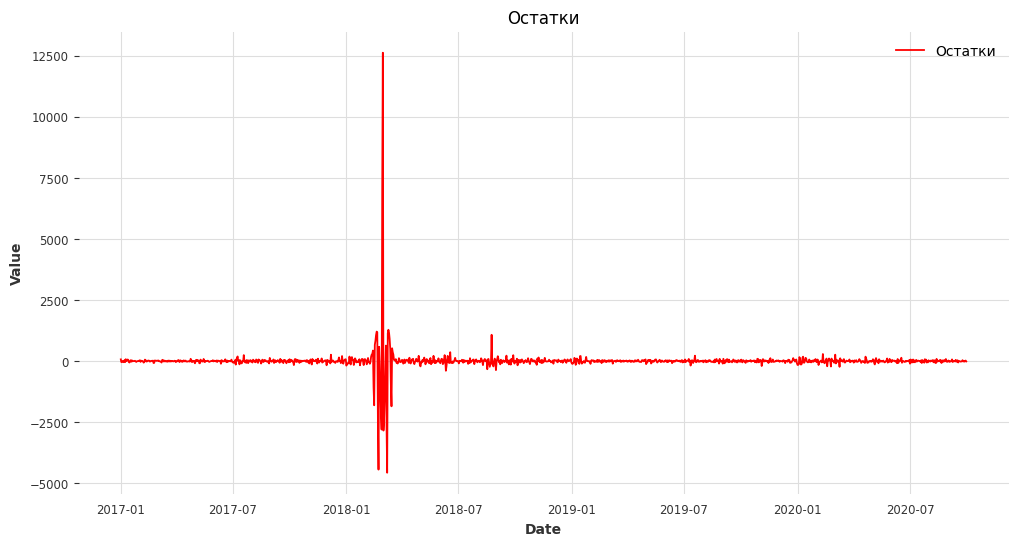

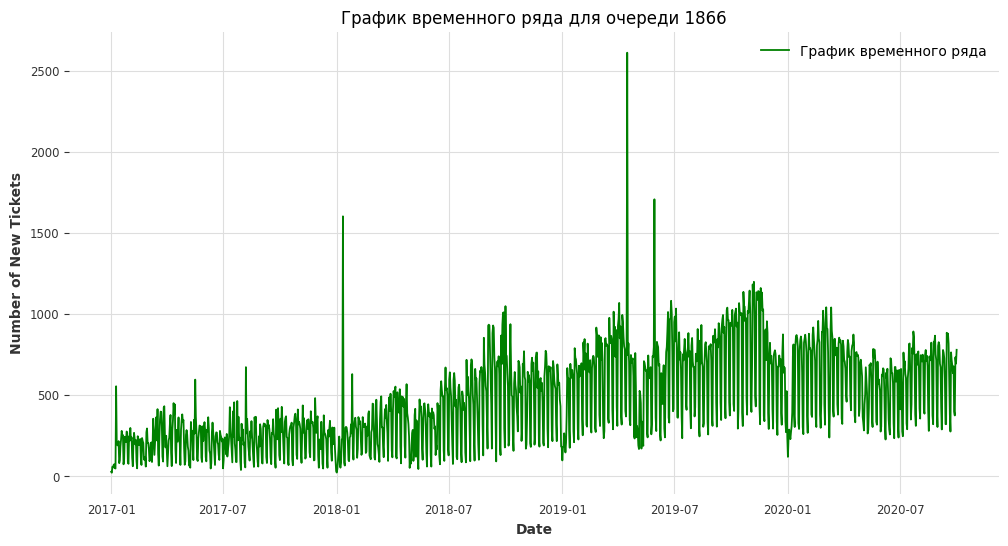

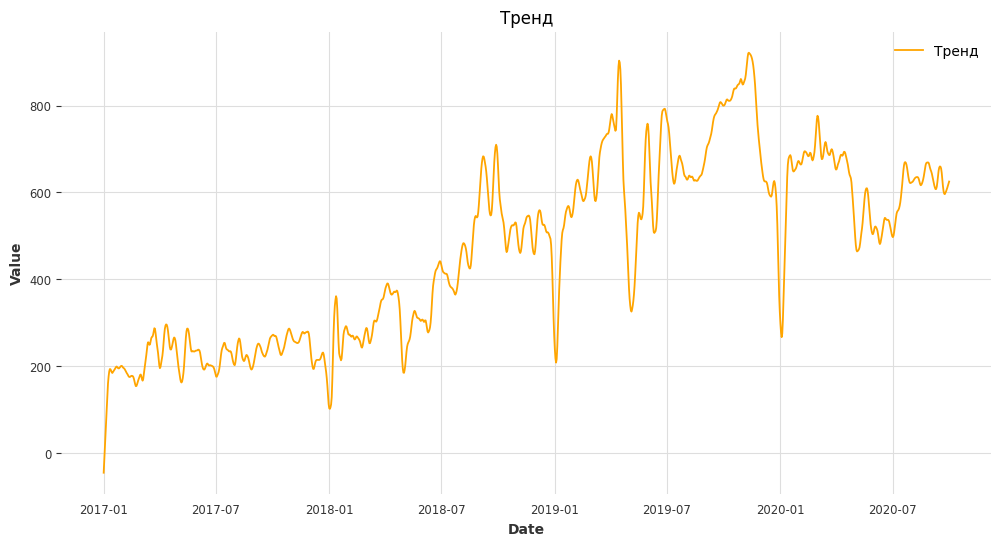

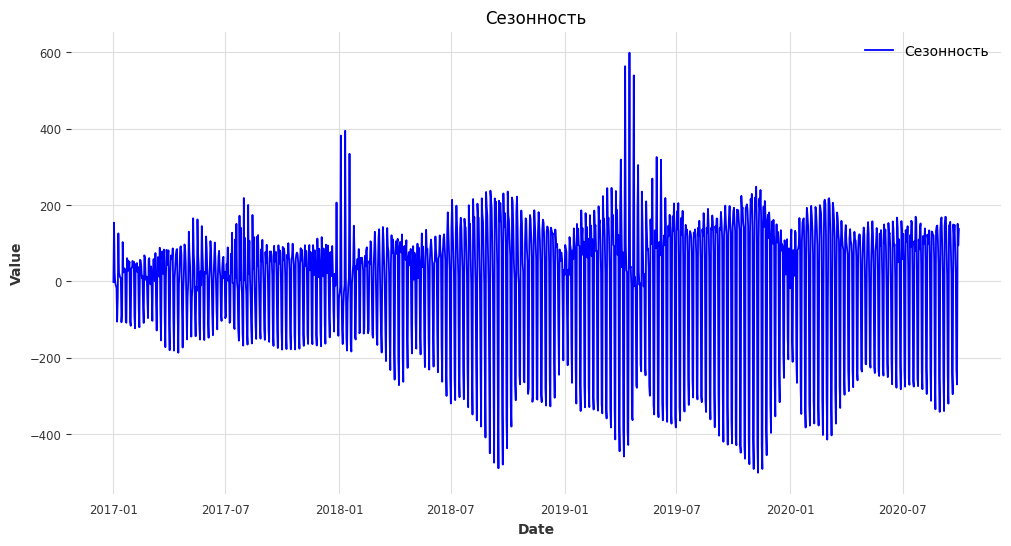

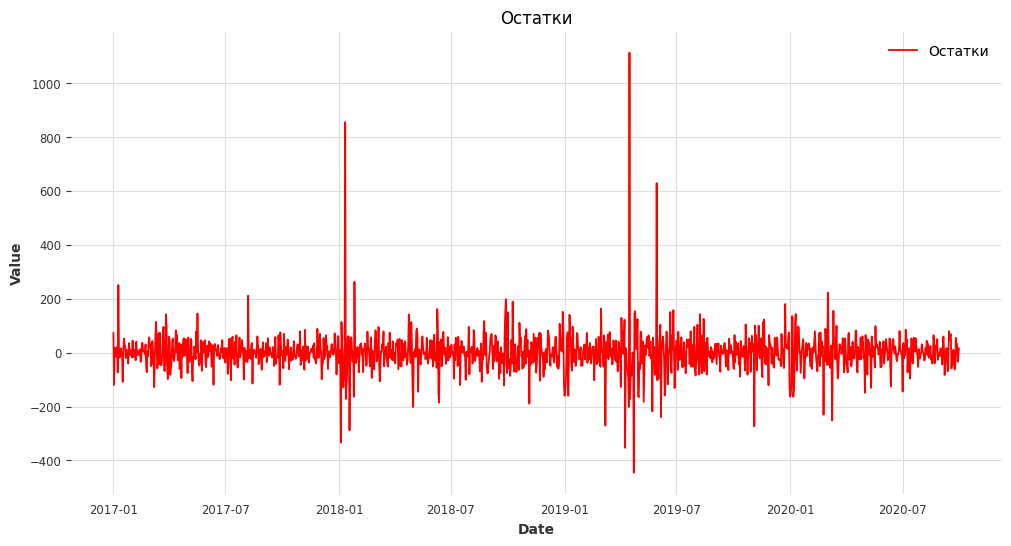

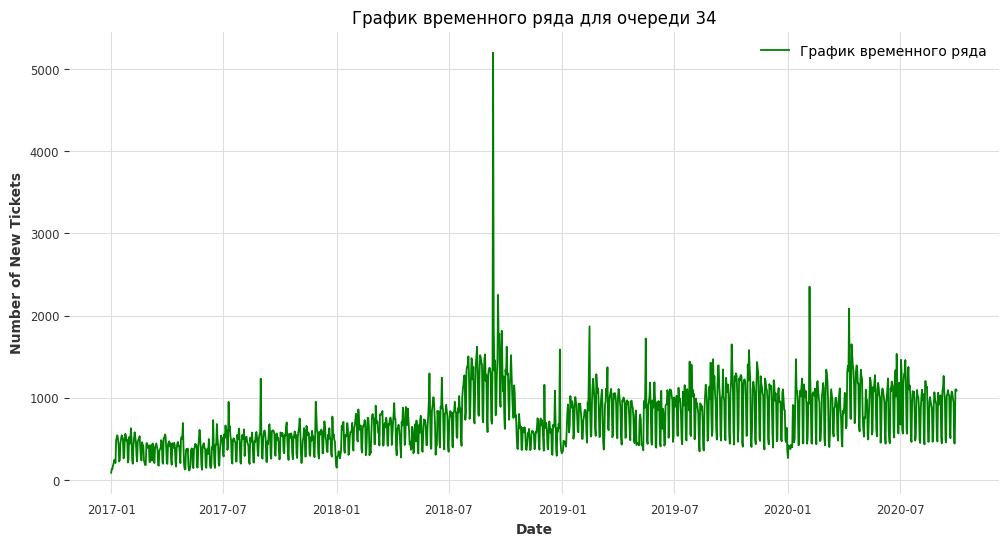

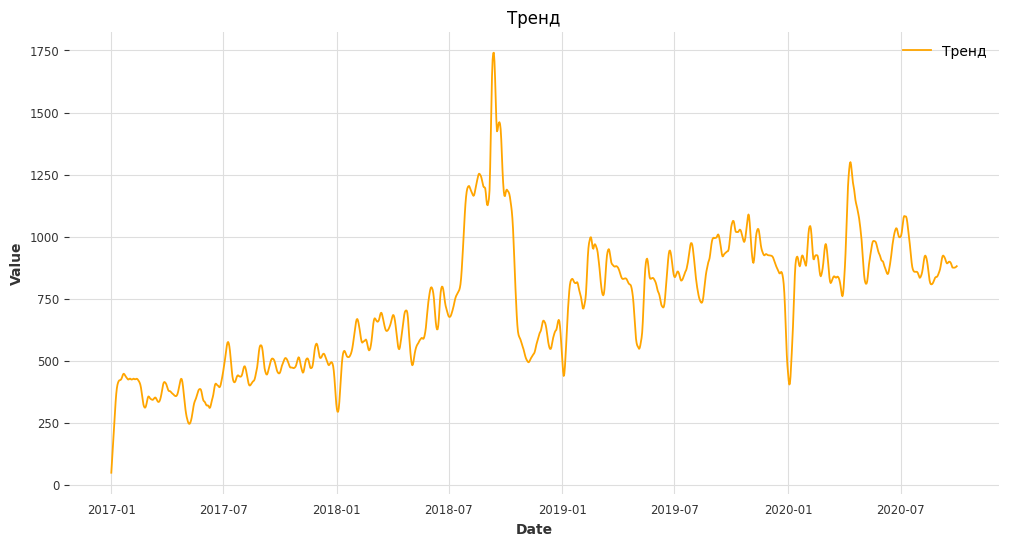

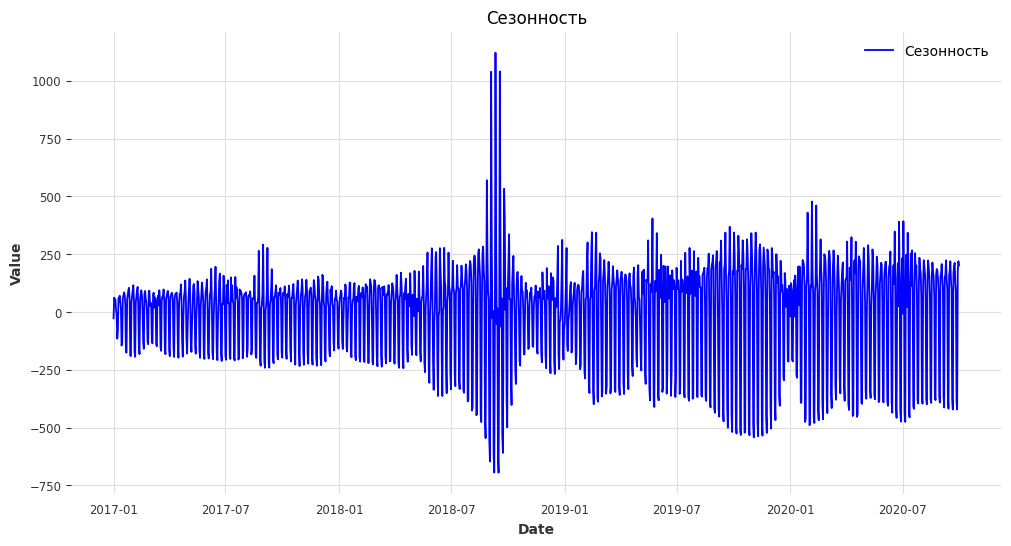

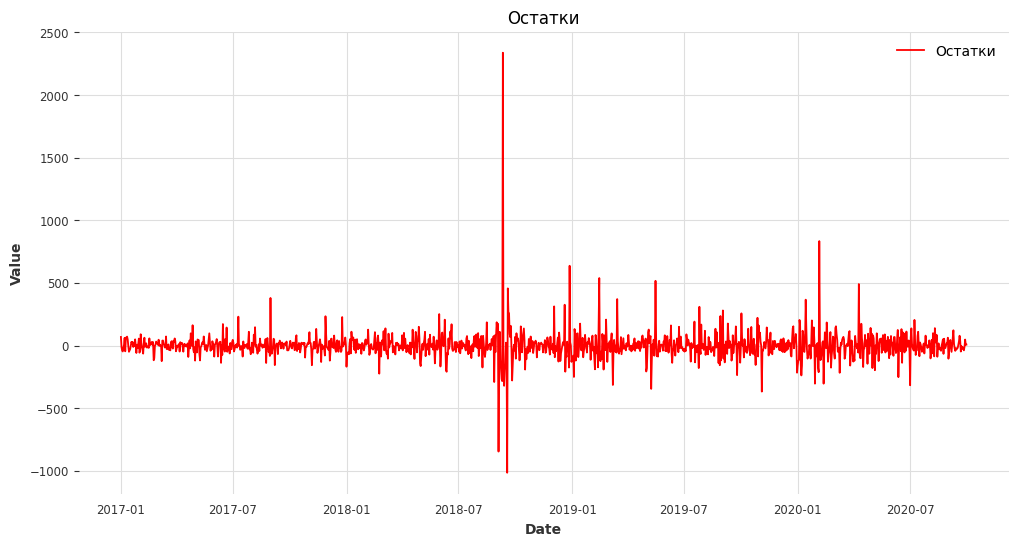

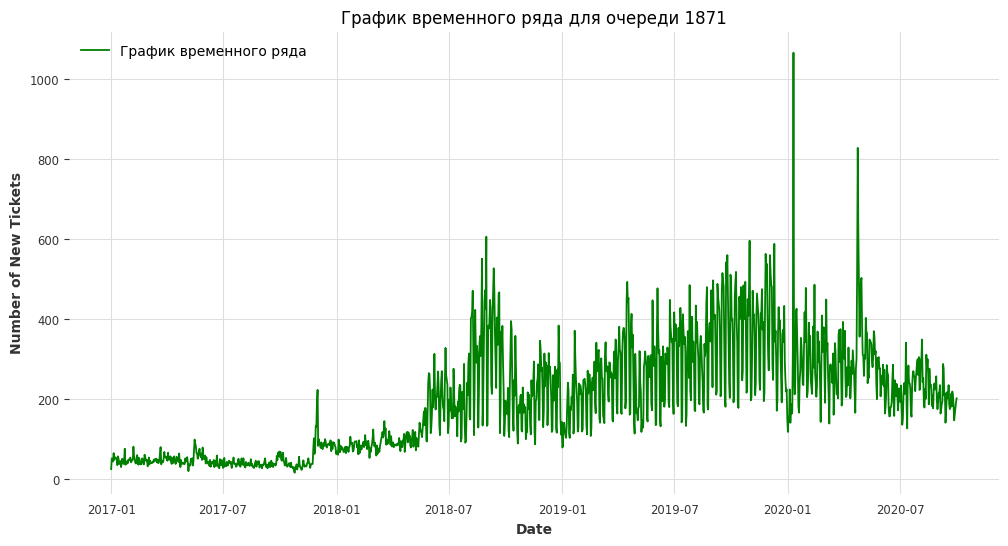

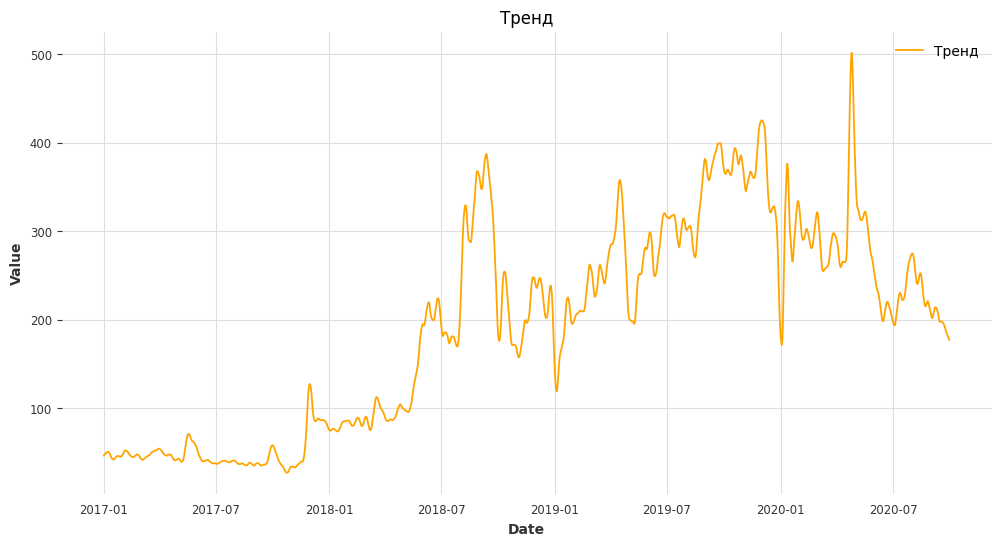

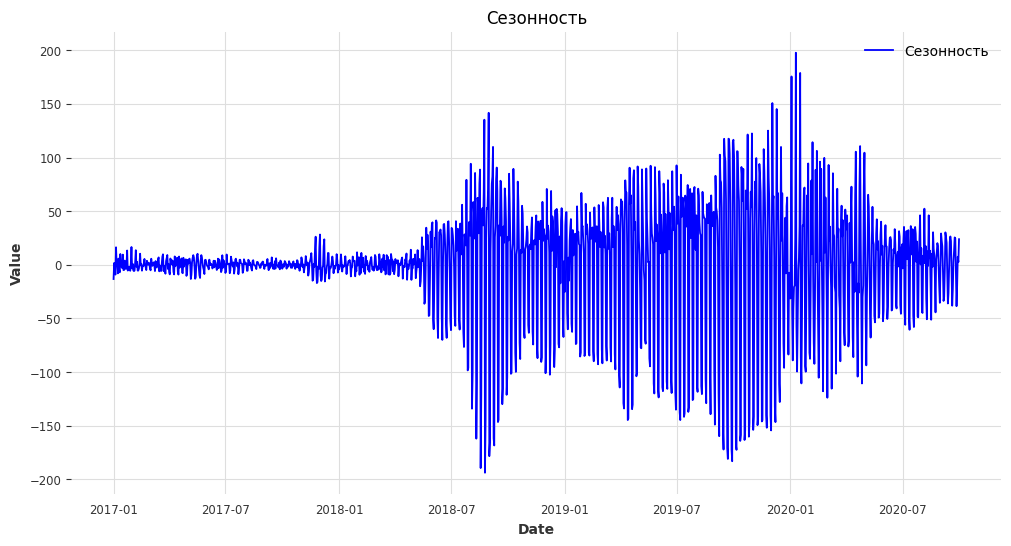

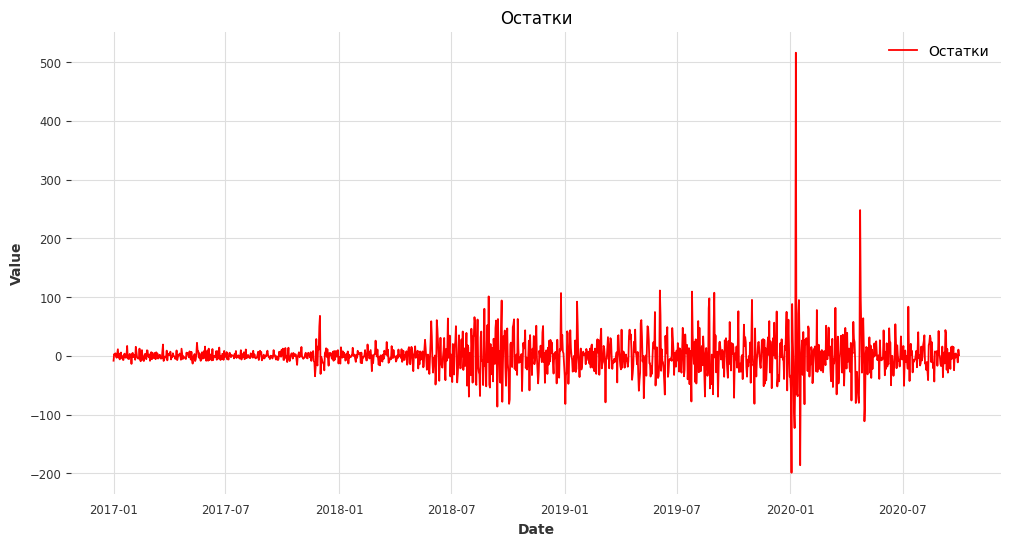

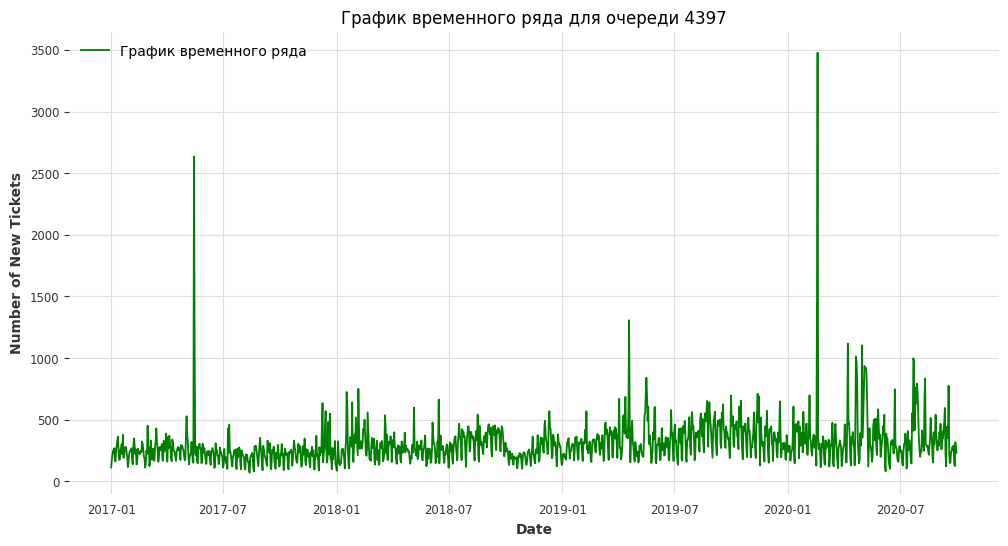

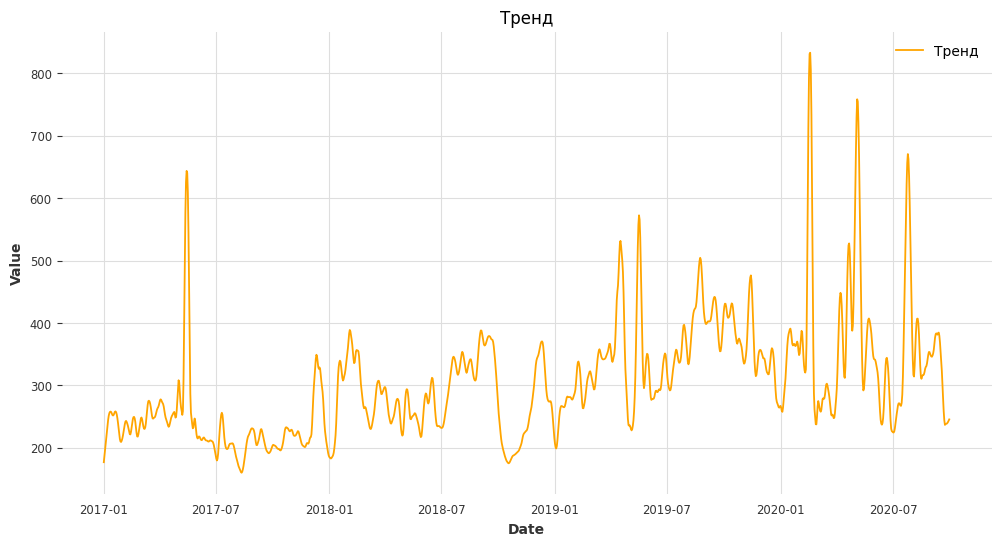

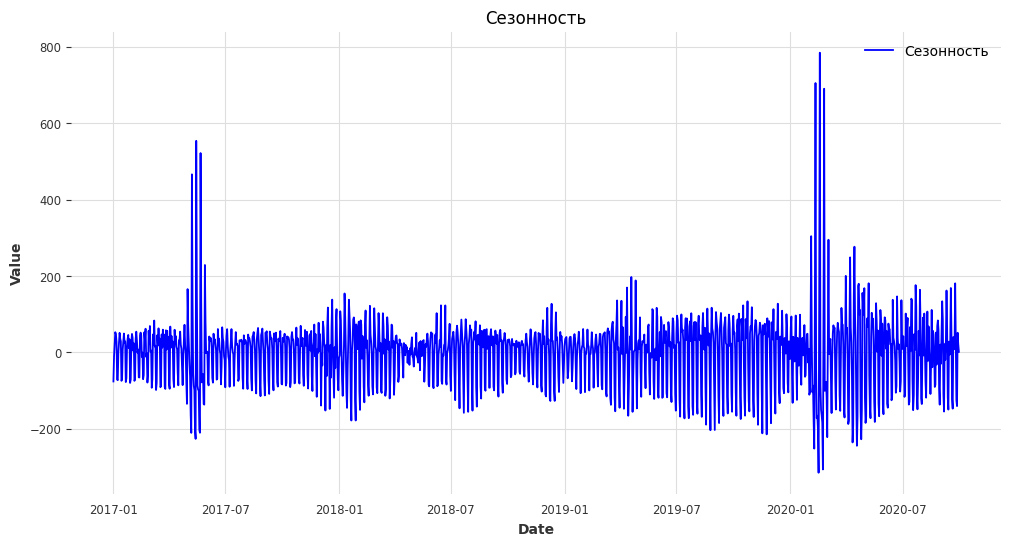

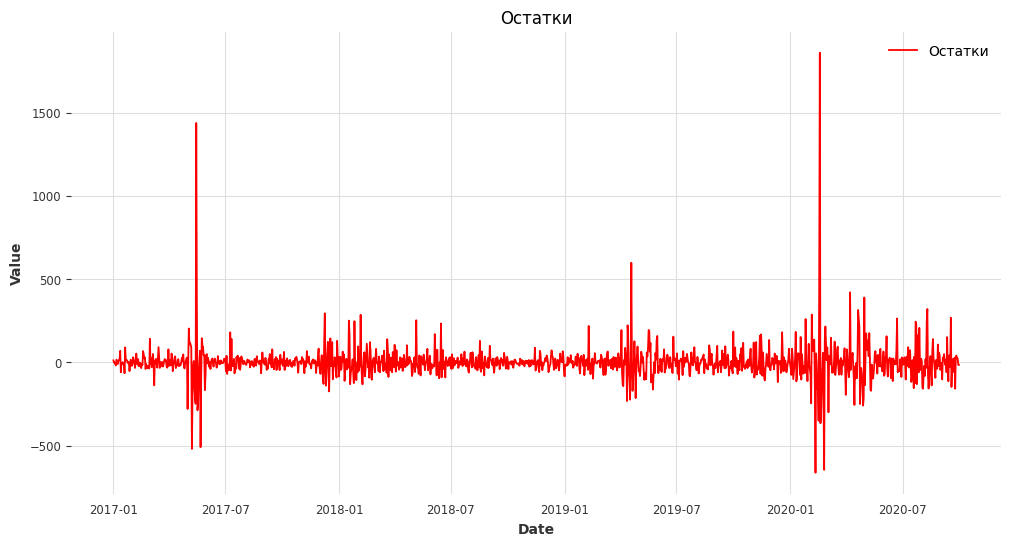

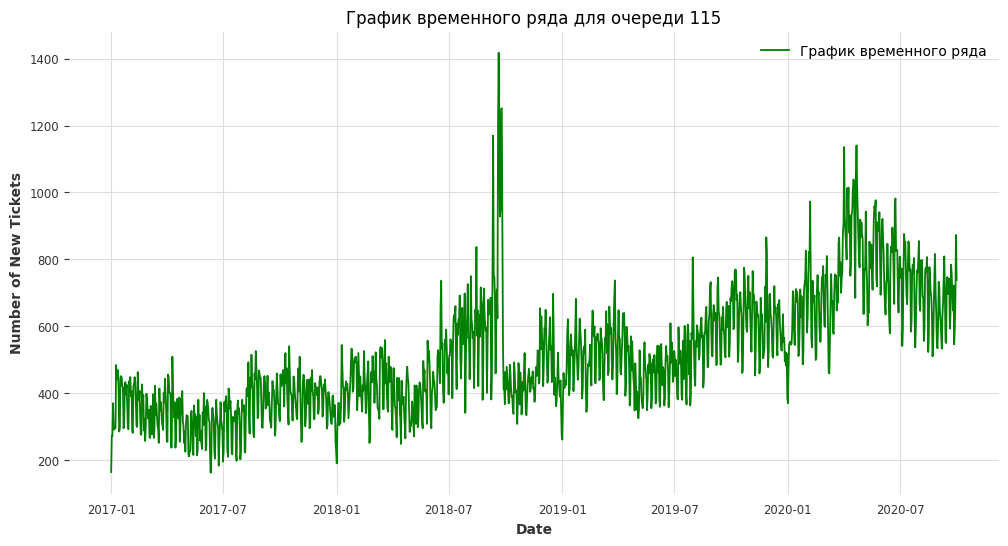

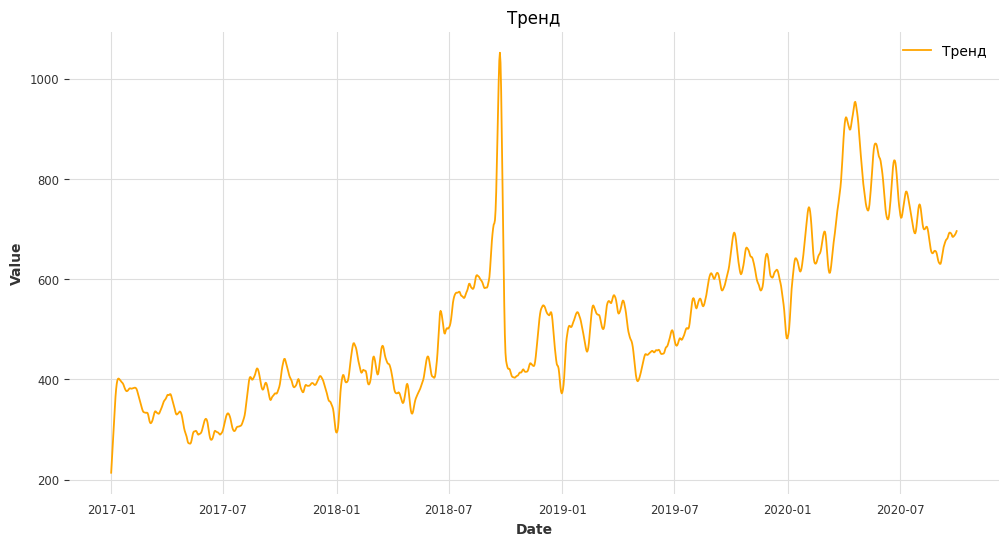

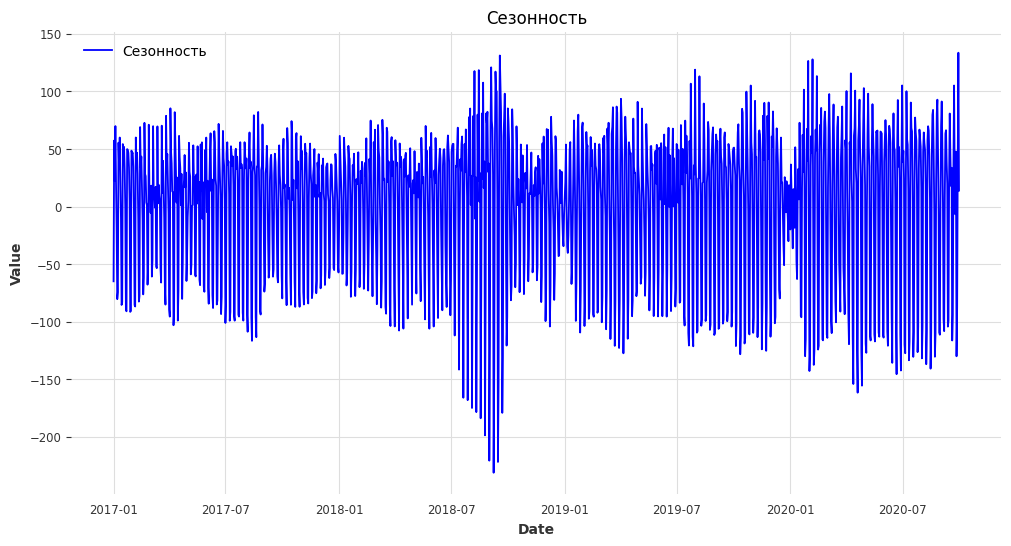

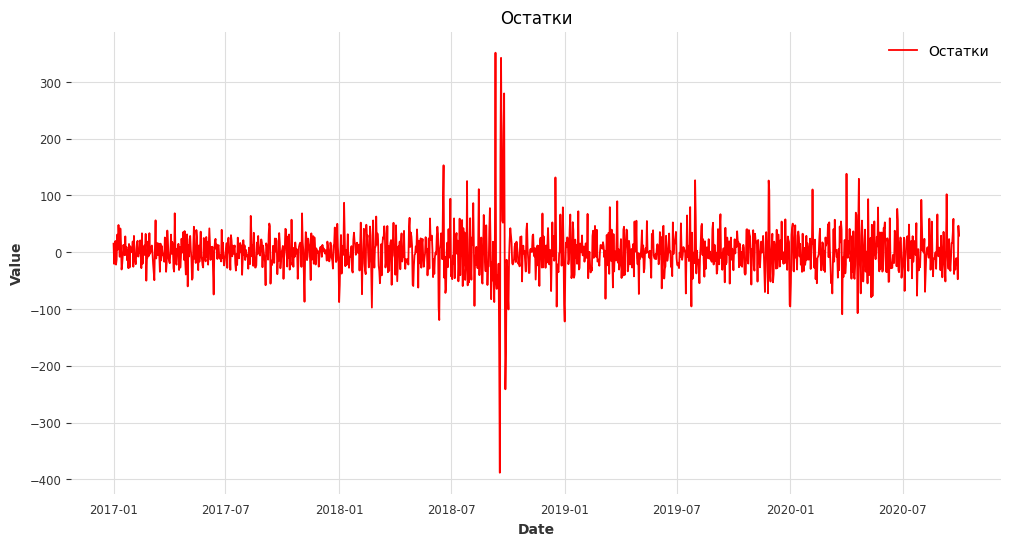

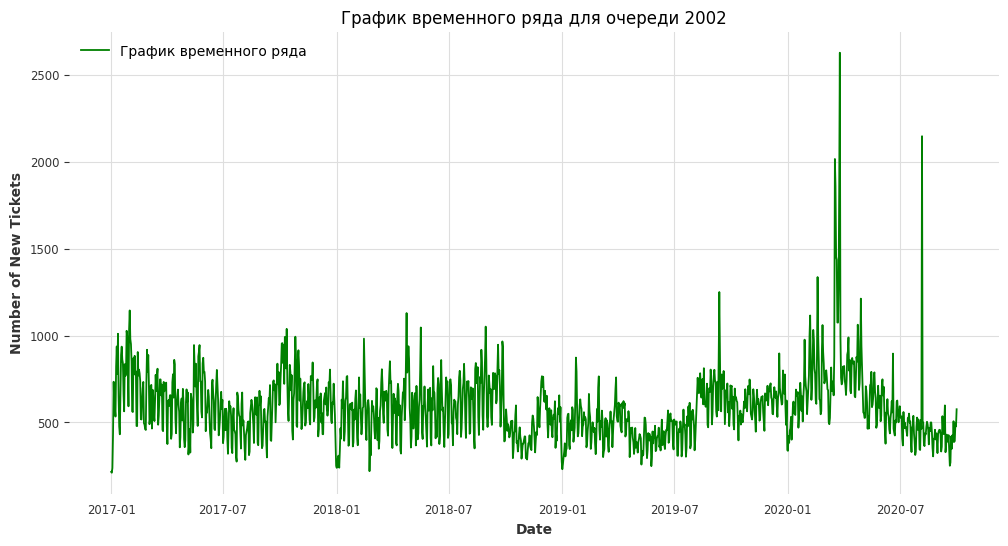

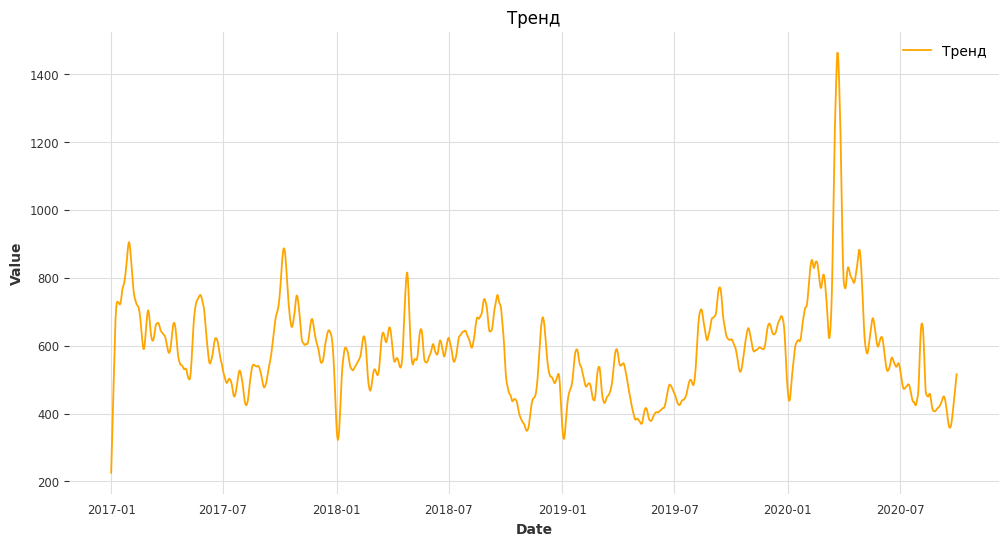

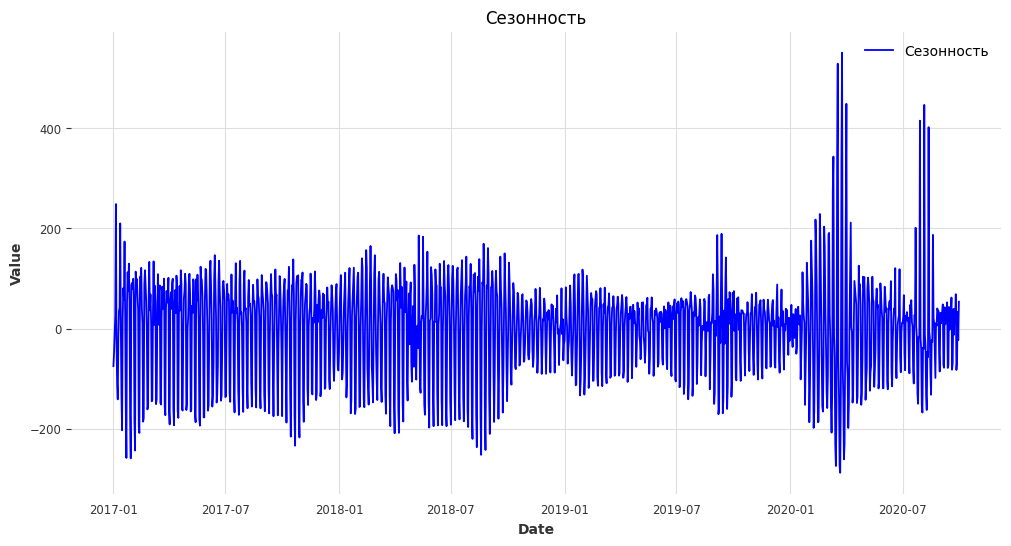

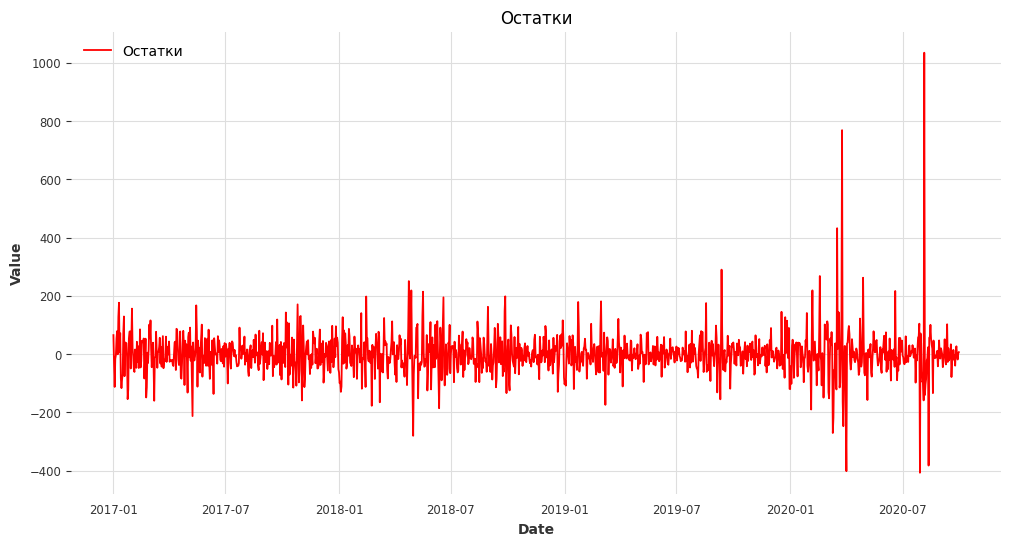

In [27]:
analyze_queues_stl_children(df, tree, top_queues)

Исходя из полученных графиков можно увидеть, что в большинстве популярных очередей был выброс в начале 20 года. 

# Аналитика в разрезе очередей

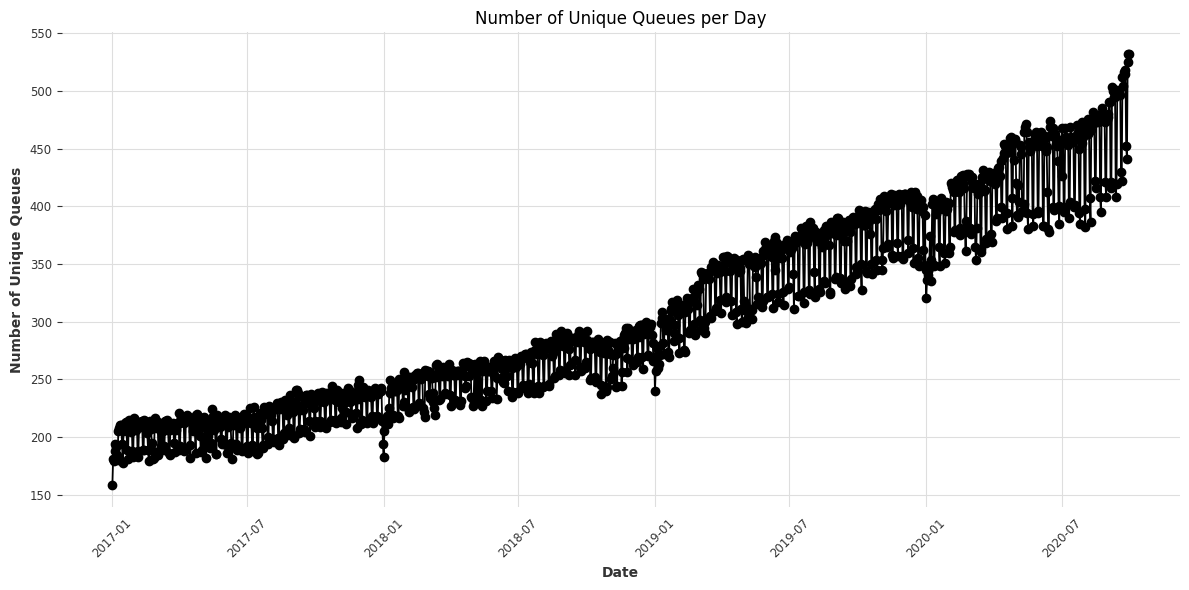

In [28]:
unique_queues = df.groupby("date")["queueId"].nunique().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(unique_queues["date"], unique_queues["queueId"], marker="o")
plt.title("Number of Unique Queues per Day")
plt.xlabel("Date")
plt.ylabel("Number of Unique Queues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Из графика видно, что количество очередей растет. Это говорит о том, что продукт развивается, и растет количество обращений в тех. поддержку.

In [29]:
def plot_top_queues_tickets(df, tree, top_queues):
    plt.figure(figsize=(12, 10))

    for parent_queue_id in top_queues:
        # Проверяем, есть ли родительская очередь в оригинальном датасете
        if parent_queue_id in df["queueId"].values:
            # Находим родительскую очередь в дереве
            parent_row = tree[tree["queueId"] == parent_queue_id]

            if not parent_row.empty:
                children_ids = parent_row.iloc[0]["immediateDescendants"]

                # Фильтруем данные для дочерних очередей
                child_tickets = df[df["queueId"].isin(children_ids)]

                # Группируем по дате и суммируем тикеты
                parent_daily_tickets = (
                    child_tickets.groupby("date")["new_tickets"].sum().reset_index()
                )

                # Строим график для родительской очереди
                plt.plot(
                    parent_daily_tickets["date"],
                    parent_daily_tickets["new_tickets"],
                    label=f"Parent Queue {parent_queue_id}",
                )

    plt.title("Количество тикетов для родительских очередей")
    plt.xlabel("Дата")
    plt.ylabel("Количество новых тикетов")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()  # Удобная подгонка для отображения меток
    plt.show()


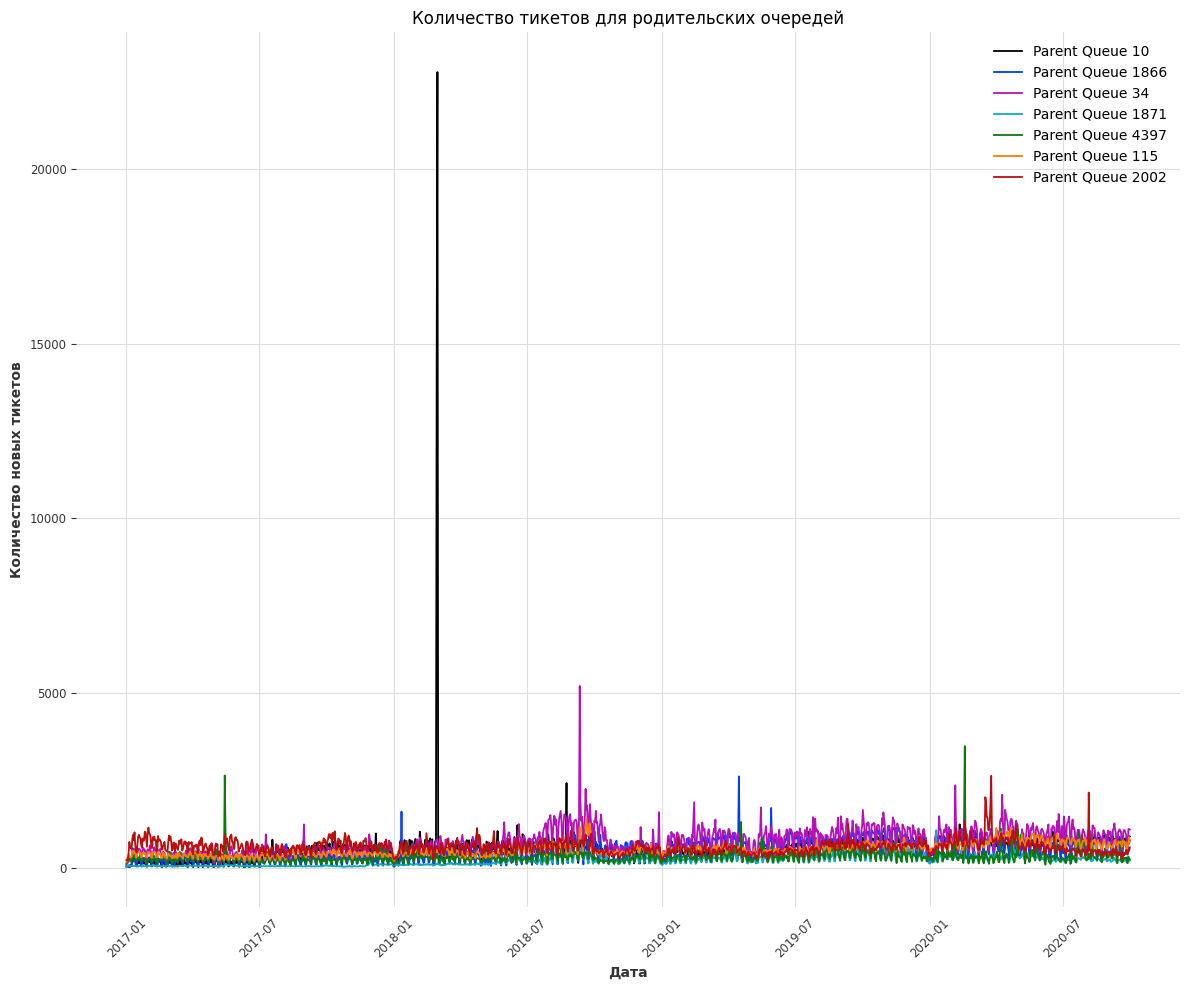

In [30]:
plot_top_queues_tickets(df, tree, top_queues)

# Проверим сезонность, автокорреляцию, лаги с помощью тестов ACF, PACF, ADF

In [31]:
def analyze_queues(df, tree, top_queues):
    adf_results = {}

    for parent_queue_id in top_queues:
        # Проверяем, есть ли родительская очередь в оригинальном датасете
        if parent_queue_id in df["queueId"].values:
            # Находим родительскую очередь в дереве
            parent_row = tree[tree["queueId"] == parent_queue_id]

            if not parent_row.empty:
                children_ids = parent_row.iloc[0]["immediateDescendants"]

                # Фильтруем данные для дочерних очередей
                child_tickets = df[df["queueId"].isin(children_ids)]

                # Группируем по дате и суммируем тикеты
                queue_data = (
                    child_tickets.groupby("date")["new_tickets"]
                    .sum()
                    .reset_index()
                    .set_index("date")["new_tickets"]
                )

                # ADF
                adf_result = adfuller(queue_data)
                adf_results[parent_queue_id] = {
                    "ADF Statistic": adf_result[0],
                    "p-value": adf_result[1],
                    "Critical Values": adf_result[4],
                }

                plt.figure(figsize=(12, 6))

                # ACF
                plt.subplot(1, 2, 1)
                plot_acf(
                    queue_data,
                    lags=30,
                    ax=plt.gca(),
                    title=f"ACF for Queue {parent_queue_id}",
                    zero=False,
                )

                # PACF
                plt.subplot(1, 2, 2)
                plot_pacf(
                    queue_data,
                    lags=30,
                    ax=plt.gca(),
                    title=f"PACF for Queue {parent_queue_id}",
                    zero=False,
                )

                plt.tight_layout()
                plt.show()
            else:
                print(
                    f"Parent Queue ID {parent_queue_id} has no immediate descendants."
                )
        else:
            print(f"Queue ID {parent_queue_id} does not exist in the dataset.")

    for queue_id, results in adf_results.items():
        print(f"Queue ID: {queue_id}")
        print(f"  ADF Statistic: {results['ADF Statistic']:.4f}")
        print(f"  p-value: {results['p-value']:.4f}")
        print("  Critical Values:")
        for key, value in results["Critical Values"].items():
            print(f"    {key}: {value:.4f}")
        print()

    return adf_results


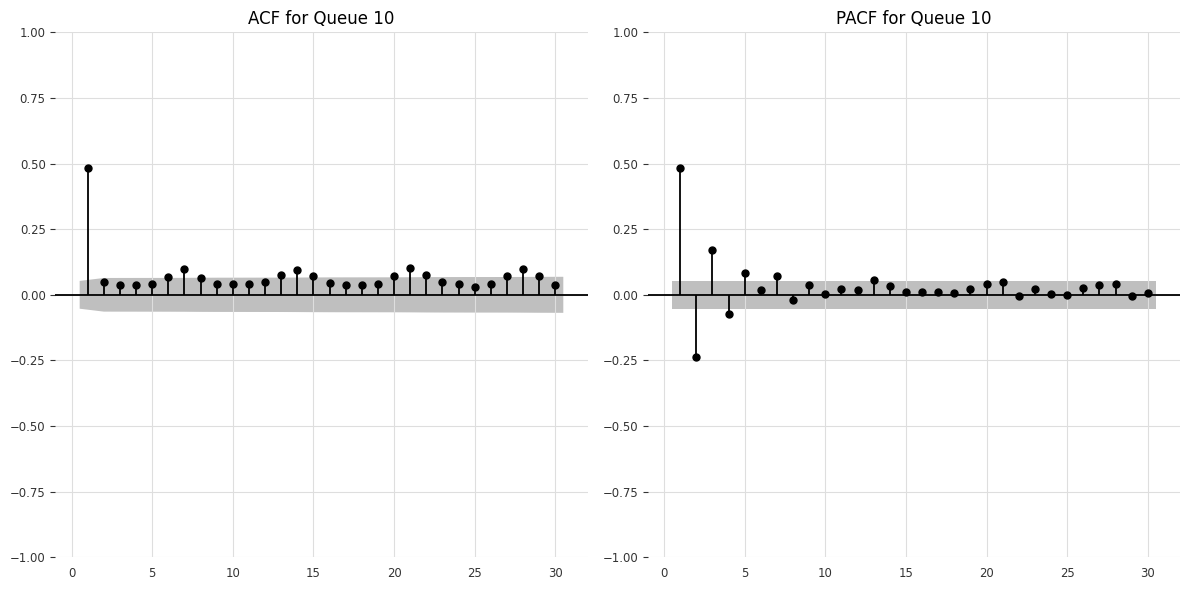

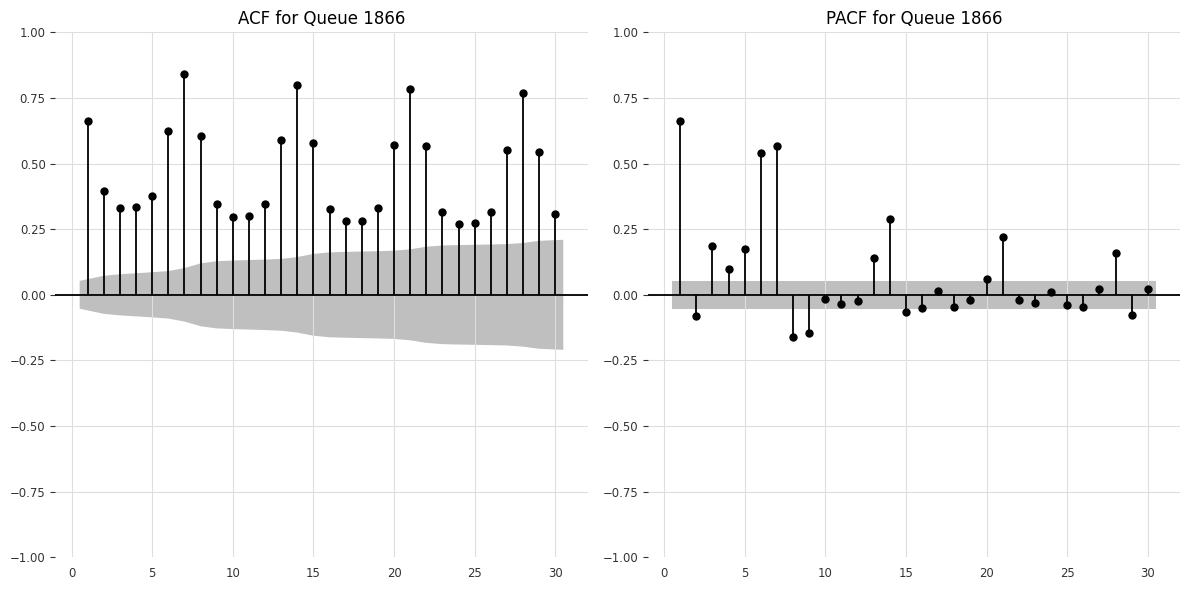

Queue ID 742 does not exist in the dataset.


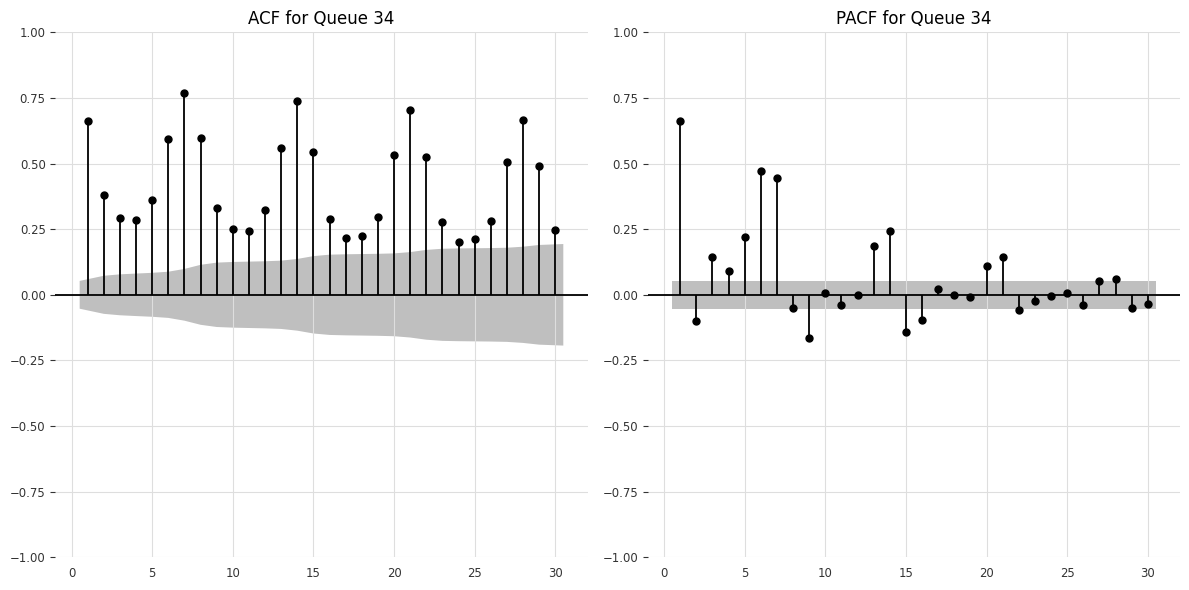

Queue ID 2657 does not exist in the dataset.
Queue ID 4447 does not exist in the dataset.


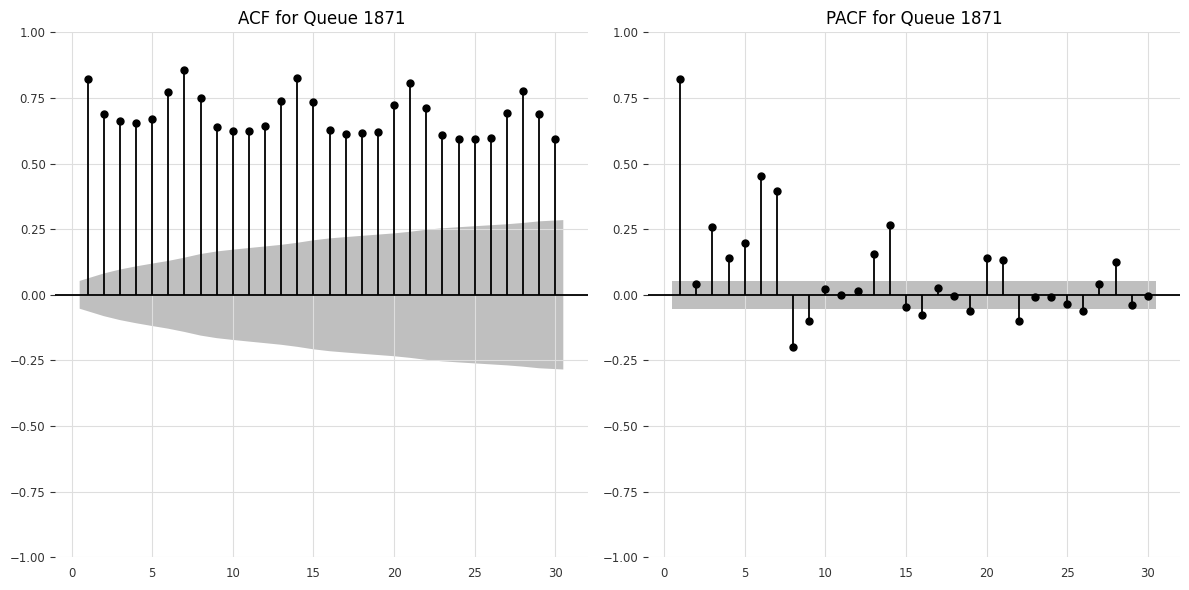

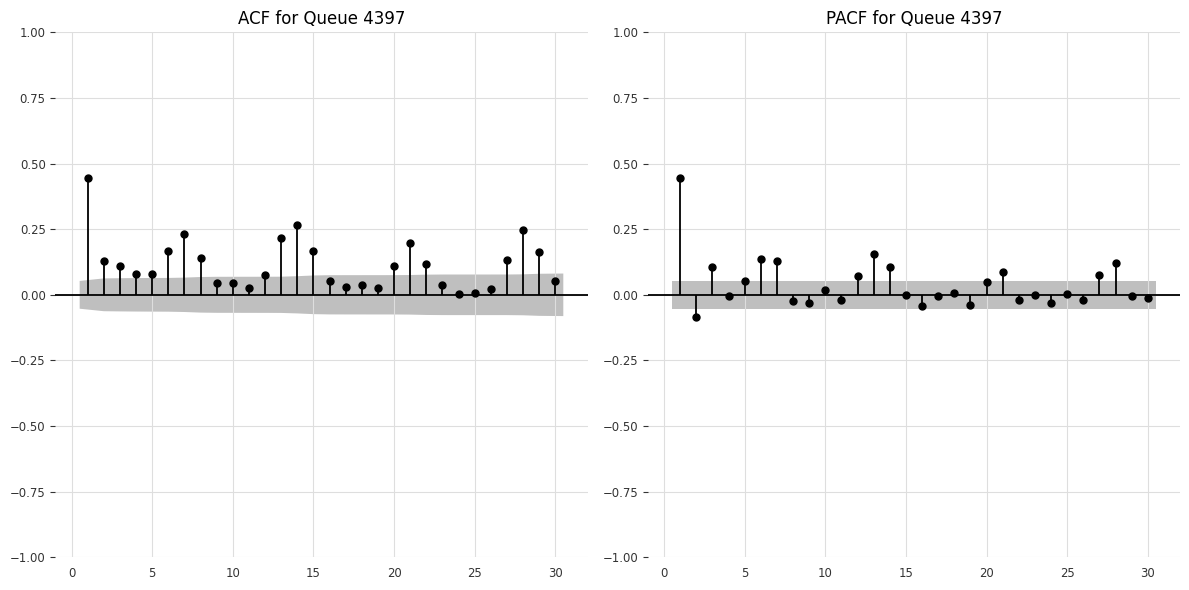

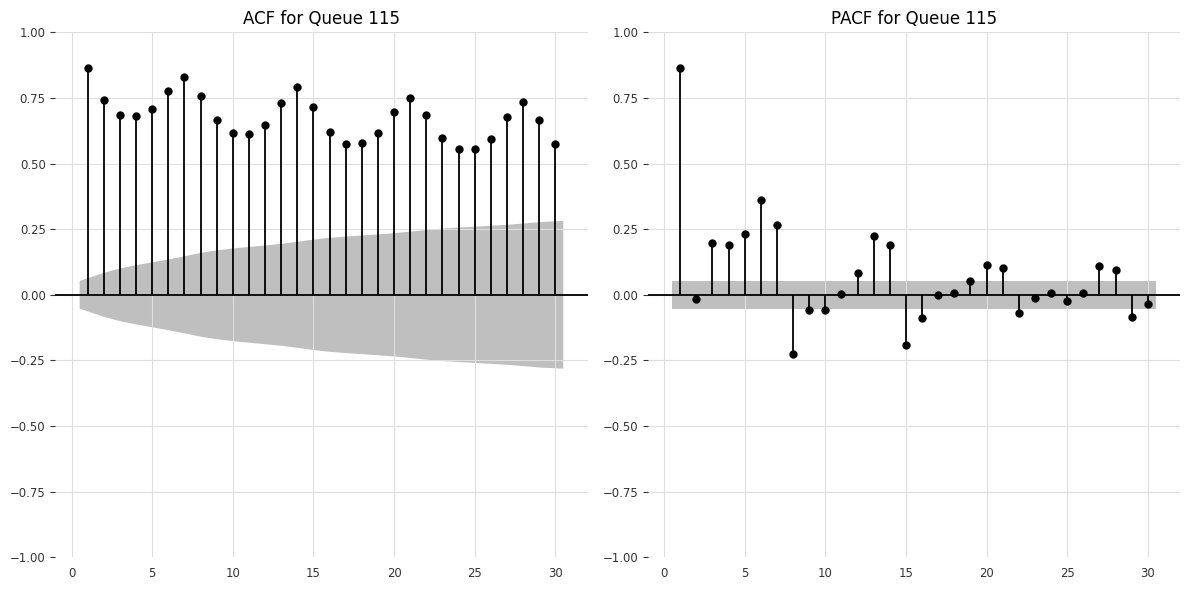

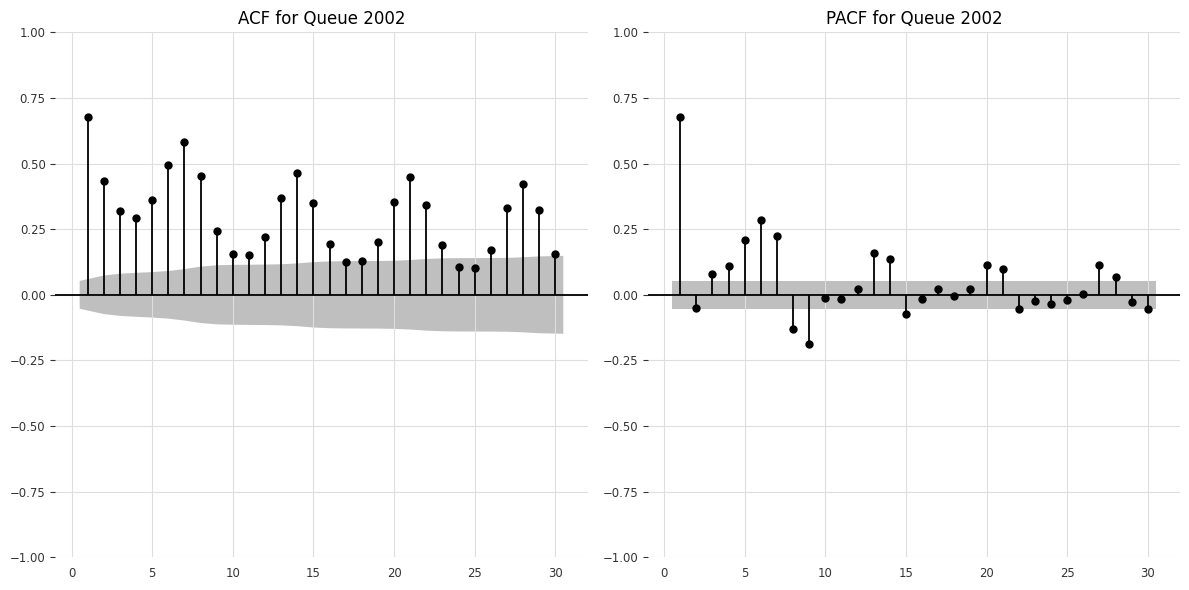

Queue ID: 10
  ADF Statistic: -11.2185
  p-value: 0.0000
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 1866
  ADF Statistic: -2.0093
  p-value: 0.2825
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 34
  ADF Statistic: -2.5272
  p-value: 0.1090
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 1871
  ADF Statistic: -1.8777
  p-value: 0.3426
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 4397
  ADF Statistic: -4.9576
  p-value: 0.0000
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 115
  ADF Statistic: -2.0232
  p-value: 0.2765
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 2002
  ADF Statistic: -3.7384
  p-value: 0.0036
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

{10: {'ADF Statistic': -11.218482481647488, 'p-value': 2.0413190245952227e-20, 'Critical Values': {'1%': -3.4351603

In [32]:
print(analyze_queues(df, tree, top_queues))

Исходя из тестов ACF, PACF, ADF можно сделать следующие выводы - 

1. Очередь 10:

ADF Statistic: -11.2185
p-value: 0.0000 < 0.05
Критические значения: все критические значения (1%, 5%, 10%) выше ADF Statistic
Вывод: ряд стационарен

2. Очередь 1866:

ADF Statistic: -2.0093
p-value: 0.2825 > 0.05
Критические значения: все критические значения ниже ADF Statistic
Вывод: ряд нестационарен

3. Очередь 34:

ADF Statistic: -2.5272
p-value: 0.1090 > 0.05
Критические значения: все критические значения ниже ADF Statistic
Вывод: ряд нестационарен

4. Очередь 1871:

ADF Statistic: -1.8777
p-value: 0.3426 > 0.05
Критические значения: все критические значения ниже ADF Statistic
Вывод: ряд нестационарен

5. Очередь 4397:

ADF Statistic: -4.9576
p-value: 0.0000 < 0.05
Критические значения: все критические значения выше ADF Statistic
Вывод: ряд стационарен

6. Очередь 115:

ADF Statistic: -2.0232
p-value: 0.2765 > 0.05
Критические значения: все критические значения ниже ADF Statistic
Вывод: ряд нестационарен

7. Очередь 2002:

ADF Statistic: -3.7384
p-value: 0.0036 < 0.05
Критические значения: все критические значения выше ADF Statistic
Вывод: ряд стационарен

Необходимо убрать сезонность и тренд и проверить - станет ли ряд стационарным.

In [33]:
def analyze_post_seasonality_trend(df, tree, top_queues):
    adf_results = {}

    for parent_queue_id in top_queues:
        if parent_queue_id in df["queueId"].values:
            parent_row = tree[tree["queueId"] == parent_queue_id]

            if not parent_row.empty:
                children_ids = parent_row.iloc[0]["immediateDescendants"]
                child_tickets = df[df["queueId"].isin(children_ids)]
                queue_data = (
                    child_tickets.groupby("date")["new_tickets"]
                    .sum()
                    .reset_index()
                    .set_index("date")["new_tickets"]
                )

                # Удаляем тренд и сезонность
                detrended = queue_data - queue_data.rolling(window=30).mean()
                deseasonalized = detrended - detrended.rolling(window=7).mean()

                # ADF
                adf_result = adfuller(deseasonalized.dropna())
                adf_results[parent_queue_id] = {
                    "ADF Statistic": adf_result[0],
                    "p-value": adf_result[1],
                    "Critical Values": adf_result[4],
                }

                plt.figure(figsize=(12, 6))

                # ACF
                plt.subplot(1, 2, 1)
                plot_acf(
                    deseasonalized.dropna(),
                    lags=30,
                    ax=plt.gca(),
                    title=f"ACF for Queue {parent_queue_id}",
                    zero=False,
                )

                # PACF
                plt.subplot(1, 2, 2)
                plot_pacf(
                    deseasonalized.dropna(),
                    lags=30,
                    ax=plt.gca(),
                    title=f"PACF for Queue {parent_queue_id}",
                    zero=False,
                )

                plt.tight_layout()
                plt.show()
            else:
                print(
                    f"Parent Queue ID {parent_queue_id} has no immediate descendants."
                )
        else:
            print(f"Queue ID {parent_queue_id} does not exist in the dataset.")

    for queue_id, results in adf_results.items():
        print(f"Queue ID: {queue_id}")
        print(f"  ADF Statistic: {results['ADF Statistic']:.4f}")
        print(f"  p-value: {results['p-value']:.4f}")
        print("  Critical Values:")
        for key, value in results["Critical Values"].items():
            print(f"    {key}: {value:.4f}")
        print()

    return adf_results

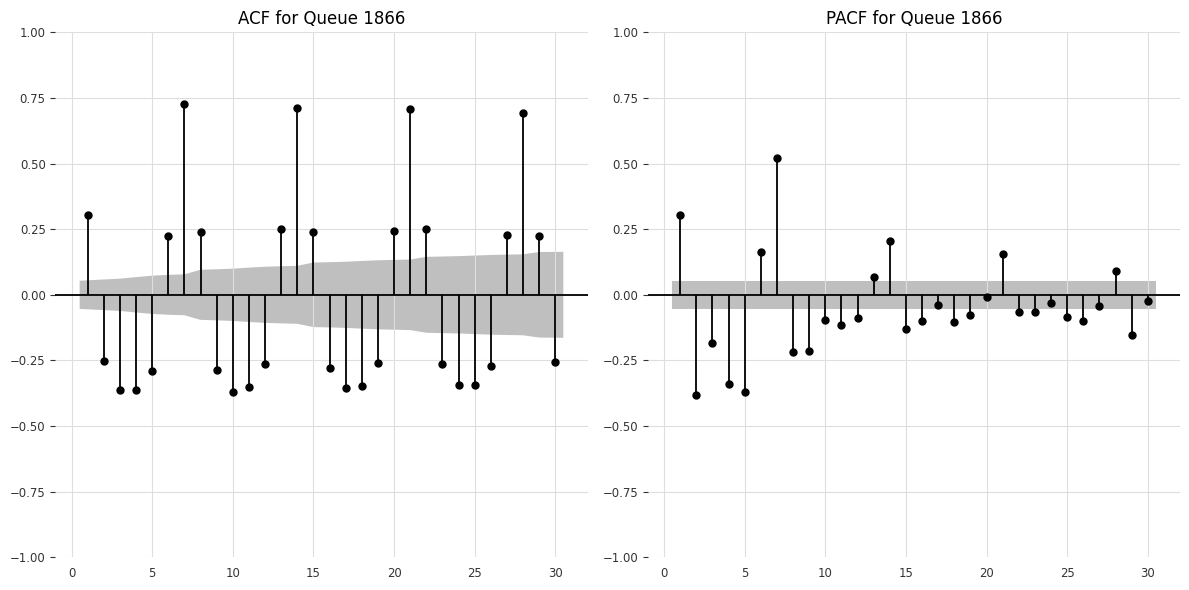

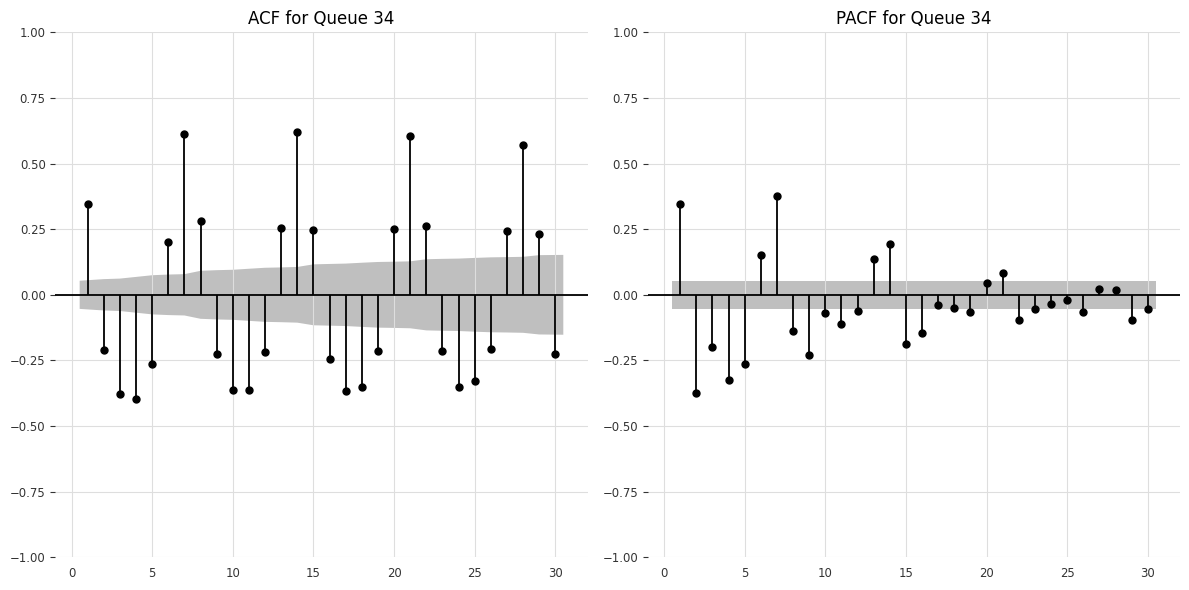

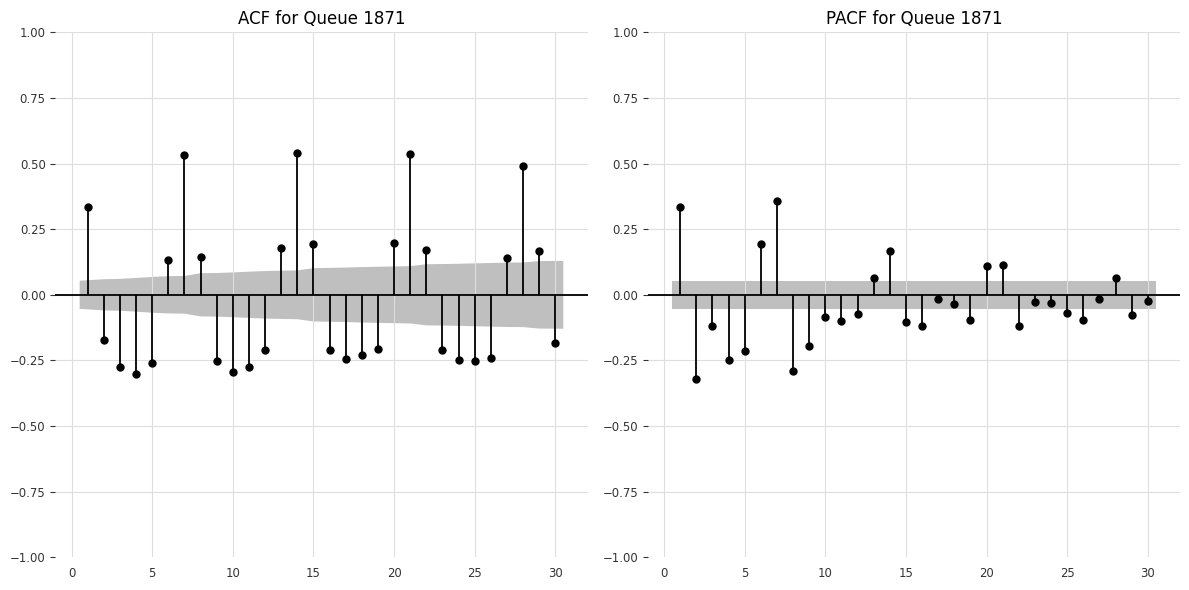

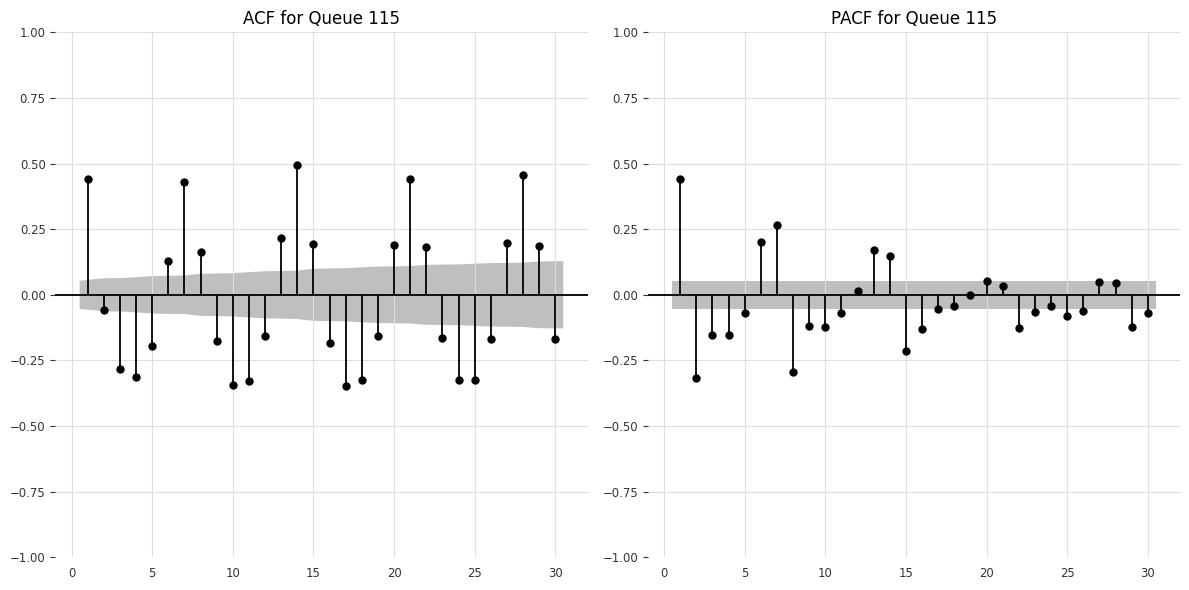

Queue ID: 1866
  ADF Statistic: -10.2191
  p-value: 0.0000
  Critical Values:
    1%: -3.4353
    5%: -2.8637
    10%: -2.5679

Queue ID: 34
  ADF Statistic: -10.4580
  p-value: 0.0000
  Critical Values:
    1%: -3.4353
    5%: -2.8637
    10%: -2.5679

Queue ID: 1871
  ADF Statistic: -9.6456
  p-value: 0.0000
  Critical Values:
    1%: -3.4353
    5%: -2.8637
    10%: -2.5679

Queue ID: 115
  ADF Statistic: -10.5432
  p-value: 0.0000
  Critical Values:
    1%: -3.4354
    5%: -2.8637
    10%: -2.5679



In [34]:
top_queues_to_process = [1866, 34, 1871, 115]
detrended_results = analyze_post_seasonality_trend(df, tree, top_queues_to_process)

После удаления сезонности и тренда, можно сделать следующие выводы: 
1. Очередь ID 1866

ADF Statistic: -10.2191
p-value: 0.0000 < 0.05
Критические значения: все критические значения выше ADF Statistic
Интерпретация: ряд стационарен

2. Очередь ID 34

ADF Statistic: -10.4580
p-value: 0.0000 < 0.05
Критические значения: все критические значения выше ADF Statistic
Интерпретация: ряд стационарен

3. Очередь ID 1871

ADF Statistic: -9.6456
p-value: 0.0000
Критические значения: все критические значения выше ADF Statistic
Интерпретация: ряд стационарен

4. Очередь ID 115

ADF Statistic: -10.5432
p-value: 0.0000 < 0.05
Критические значения: все критические значения выше ADF Statistic
Интерпретация: ряд стационарен

# Итог
Все очереди стали стационарными. Это означает, что данные больше не имеют значимого тренда или сезонности, что делает их подходящими для дальнейшего анализа и моделирования, таких как ARIMA.